In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import sys
from numpy.fft import fftshift,ifft,fft
from scipy.signal import hilbert
sys.path.append(r'C:\Users\USER\Documents\GitHub\DLOCT\Analysis_cGAN')
from Deep_Utils import dbscale

def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

def read_tomogram2(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width))
    return tomogram

def normalize_tomogram(tomogram):
    z, x, y, _ = tomogram.shape
    normalized_tomogram = np.zeros_like(tomogram)
    max_values = np.zeros((y, 2))
    min_values = np.zeros((y, 2))
    c = 0.0001
    tomogram = 10*np.log10(abs(tomogram+c)**2)
    for i in range(y):
        for j in range(2):  # Real and imaginary parts
            bscan = tomogram[:, :, i, j]
            max_val = np.max(bscan)
            min_val = np.min(bscan)
            normalized_tomogram[:, :, i, j] = (bscan - min_val) / (max_val - min_val)
            max_values[i, j] = max_val
            min_values[i, j] = min_val
    return normalized_tomogram, max_values, min_values

def denormalize_tomogram(normalized_tomogram, max_values, min_values):
    z, x, y, _ = normalized_tomogram.shape
    denormalized_tomogram = np.zeros_like(normalized_tomogram)
    c = 0.0001
    for i in range(y):
        for j in range(2):  # Real and imaginary parts
            bscan_normalized = normalized_tomogram[:, :, i, j]
            max_val = max_values[i, j]
            min_val = min_values[i, j]
            denormalized_tomogram[:, :, i, j] = bscan_normalized * (max_val - min_val) + min_val
    denormalized_tomogram = np.sqrt(10**(denormalize_tomogram/10))-c
    return denormalized_tomogram

def denormalize_bscan(normalized_tomogram, max_values, min_values):
    denormalized_tomogram = np.zeros_like(normalized_tomogram)
    c = 0.0001
    for j in range(2):  # Real and imaginary parts
        bscan_normalized = normalized_tomogram[:, :, j]
        max_val = max_values[j]
        min_val = min_values[j]
        denormalized_tomogram[:, :, j] = bscan_normalized * (max_val - min_val) + min_val
        denormalized_tomogram = np.sqrt(10**(denormalize_tomogram/10))-c
    return denormalized_tomogram

In [2]:
pathcomplex = r'E:\DLOCT\Experimental_Data_complex\tomogram_artifacts\depth_nail'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        print(f'real: {real_file_path}')
        print(f'imag: {imag_file_path}')
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram2(real_file_path, dimensions)
        tomImag = read_tomogram2(imag_file_path, dimensions)
        tomcc = np.stack((tomReal,tomImag),axis=3)
        del tomImag, tomReal
        tomcc = tomcc[:,:,0:10,:]


pathcomplex = r'E:\DLOCT\Experimental_Data_complex\tomogram_no_artifacts\depth_nail'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        print(f'real: {real_file_path}')
        print(f'imag: {imag_file_path}')
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram2(real_file_path, dimensions)
        tomImag = read_tomogram2(imag_file_path, dimensions)
        tom = np.stack((tomReal,tomImag),axis=3)
        del tomImag, tomReal
        tom = tom[:,:,0:10,:]


real: E:\DLOCT\Experimental_Data_complex\tomogram_artifacts\depth_opticNerve\Tom_Real_CC_z=1024_x=1024_y=720.bin
imag: E:\DLOCT\Experimental_Data_complex\tomogram_artifacts\depth_opticNerve\Tom_Imag_CC_z=1024_x=1024_y=720.bin
real: E:\DLOCT\Experimental_Data_complex\tomogram_no_artifacts\depth_opticNerve\Tom_Real_CC_z=1024_x=1024_y=720.bin
imag: E:\DLOCT\Experimental_Data_complex\tomogram_no_artifacts\depth_opticNerve\Tom_Imag_CC_z=1024_x=1024_y=720.bin


In [3]:
tom.shape

(1024, 1024, 10, 2)

Text(0.5, 1.0, 'artifacts')

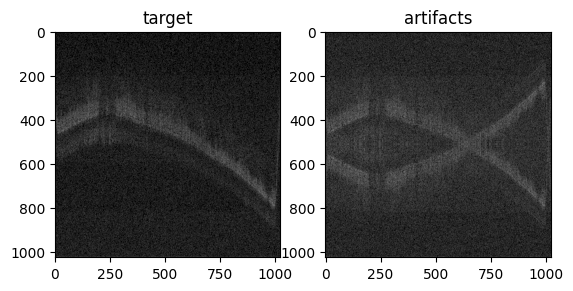

In [4]:
n = 8
c = 0.0001
fig,axs = plt.subplots(ncols=2,nrows=1)
axs[0].imshow(dbscale(tom[:,:,n,:]+c),cmap='gray',vmax=130,vmin=50)
axs[0].set_title('target')
axs[1].imshow(dbscale(tomcc[:,:,n,:]+c),cmap='gray',vmax=130,vmin=50)
axs[1].set_title('artifacts')

In [5]:
# import matplotlib.animation as animation
# c = 0.0001
# fig, axs = plt.subplots(ncols=2, nrows=1)

# def init():
#     axs[0].imshow(dbscale(tom[:, :, 0,:] + c), cmap='gray', vmax=130, vmin=50)
#     axs[0].set_title('target')
#     axs[1].imshow(dbscale(tomcc[:, :, 0,:] + c), cmap='gray', vmax=130, vmin=50)
#     axs[1].set_title('artifacts')
#     return axs

# def update(frame):
#     axs[0].imshow(dbscale(tom[:, :, frame,:] + c), cmap='gray', vmax=130, vmin=50)
#     axs[1].imshow(dbscale(tomcc[:, :, frame,:] + c), cmap='gray', vmax=130, vmin=50)
#     return axs

# n_frames = tom.shape[2]
# ani = animation.FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=False, interval=5)
# ani.save(filename=r"C:\Users\USER\Documents\animaciones\artifacts_chicken.html", writer="html")

In [6]:
tomNorm,tmax,tmin = normalize_tomogram(tom)
tomccNorm,imax,imin = normalize_tomogram(tomcc)

In [7]:
print(np.max(abs(tomNorm[:,:,n,0]+1j*tomNorm[:,:,n,1])))
print(np.min(abs(tomNorm[:,:,n,0]+1j*tomNorm[:,:,n,1])))

1.4142135
0.0


Text(0.5, 1.0, 'artifacts')

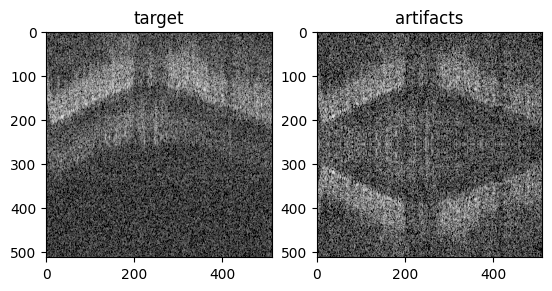

In [9]:
n = 8
size = 512
initz = 256
initx = 0
fig,axs = plt.subplots(ncols=2,nrows=1)
axs[0].imshow(abs(tomNorm[initz:initz+size,initx:initx+size,n,0]+1j*tomNorm[initz:initz+size,initx:initx+size,n,1]),cmap='gray',vmax=1.4,vmin=1)
axs[0].set_title('target')
axs[1].imshow(abs(tomccNorm[initz:initz+size,initx:initx+size,n,0]+1j*tomccNorm[initz:initz+size,initx:initx+size,n,1]),cmap='gray',vmax=1.4,vmin=1)
axs[1].set_title('artifacts')